In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
train = pd.read_csv("/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Train.csv")
test = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/Test.csv')
submission = pd.read_csv('/content/drive/My Drive/DSN AI Bootcamp Qualification Hackathon/submission.csv')
##train = pd.read_csv("Train.csv")
##test = pd.read_csv('Test.csv')
#submission = pd.read_csv('SampleSubmission.csv')

In [70]:
#train.info()

In [71]:
train.describe()

,form_field1,form_field2,form_field3,form_field4,form_field5,form_field6,form_field7,form_field8,form_field9,form_field10,form_field11,form_field12,form_field13,form_field14,form_field15,form_field16,form_field17,form_field18,form_field19,form_field20,form_field21,form_field22,form_field23,form_field24,form_field25,form_field26,form_field27,form_field28,form_field29,form_field30,form_field31,form_field32,form_field33,form_field34,form_field35,form_field36,form_field37,form_field38,form_field39,form_field40,form_field41,form_field42,form_field43,form_field44,form_field45,form_field46,form_field48,form_field49,form_field50
count,53471.000000,52156.000000,55645.000000,55645.000000,55645.000000,4.264000e+04,5.083700e+04,4.264000e+04,4.799200e+04,5.564500e+04,2.457900e+04,4.610500e+04,5.011100e+04,5.600000e+04,3.352500e+04,42964.000000,44849.000000,45598.000000,55996.000000,55645.000000,40146.000000,35600.000000,27877.000000,42703.000000,50550.000000,48562.000000,46701.000000,55645.000000,55645.000000,30491.000000,16592.000000,50550.000000,54744.000000,55645.000000,32852.000000,54005.000000,50550.000000,55645.000000,51789.000000,12271.000000,17771.000000,54677.000000,55432.000000,50617.000000,24683.000000,40096.000000,3.511100e+04,55645.000000,4.494400e+04
mean,3491.795665,0.550737,1.052225,0.851979,1.956317,6.244479e+05,6.865210e+06,2.626690e+06,1.316002e+07,1.185585e+07,2.054715e+06,2.771113e+06,6.009944e+06,6.914875e+07,1.145041e+08,0.230425,0.265692,0.271832,0.948800,1.031593,86.500380,6628.316381,6452.875072,104.558516,2624.555935,10106.554899,6190.516948,17274.315141,16518.540695,5213.246663,10857.565755,938.345321,13.926583,0.230245,0.199866,12.859069,8.480435,8.601420,0.090849,147.797977,108.117363,0.368215,6.634511,0.563377,0.072520,0.095371,3.052449e+05,1.049061,6.005862e+05
std,188.462426,0.820979,2.147768,3.157692,10.512396,1.433422e+06,1.912729e+07,3.927355e+06,1.977963e+07,2.669459e+07,4.912980e+06,4.544838e+06,2.335893e+07,2.713995e+09,1.153842e+08,0.621833,0.720198,0.725434,1.736454,1.785122,53.445528,5661.059297,5739.968774,436.670719,1964.226548,8796.472481,5390.915344,26930.742020,9666.183962,3124.491488,6049.678489,1044.597044,15.208396,0.683063,0.574002,10.621984,9.328810,7.969215,0.423802,45.085889,36.765769,0.412858,6.378946,0.196973,0.291146,0.335210,1.647757e+06,1.806160,5.842405e+06
min,2990.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.395430e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.255000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166600,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.021000,0.000000,0.000000,0.000000,0.048528,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00
25%,3358.000000,0.070788,0.000000,0.000000,0.000000,1.400400e+04,6.869740e+05,1.929440e+05,1.368502e+06,4.500730e+05,2.172565e+05,2.758010e+05,1.921660e+05,1.657646e+07,5.007636e+07,0.000000,0.000000,0.000000,0.000000,0.000000,40.305000,1068.667500,797.145000,14.865000,1231.500000,3375.000000,2068.000000,60.000000,9765.000000,2312.000000,6297.000000,194.000000,2.333400,0.000000,0.000000,6.000000,2.000000,4.000000,0.000000,136.191750,87.055500,0.000000,2.020000,0.411672,0.000000,0.000000,7.710079e+01,0.000000,4.560141e-02
50%,3484.000000,0.267575,0.062000,0.000000,0.000000,1.155330e+05,2.704328e+06,9.639420e+05,5.506295e+06,3.707559e+06,6.986440e+05,1.163110e+06,1.605792e+06,2.814143e+07,8.442428e+07,0.000000,0.000000,0.000000,0.000000,0.000000,89.167500,5976.225000,5548.935000,60.660000,2203.500000,8214.000000,5110.000000,486.000000,15057.000000,5658.000000,10584.000000,598.000000,7.833400,0.000000,0.000000,10.000000,6.000000,6.000000,0.000000,150.000000,118.441500,0.220000,5.050000,0.588648,0.000000,0.000000,3.181243e+02,0.000000,1.703996e-01
75%,3620.000000,0.719512,1.282000,0.000000,0.000000,5.259280e+05,6.993831e+06,3.751516e+06,1.694552

In [72]:
#train.isnull().sum()/len(train) * 100

In [109]:
new_train = train.drop(columns=['form_field31','form_field40','form_field41'])
#new_train = train
#print(new_train.head())

In [110]:
#test.isnull().sum()/len(test) * 100

In [111]:
new_test = test.drop(columns=['form_field31','form_field40','form_field41'])
#new_test = test

## Feature Engineering

In [112]:
new_train.fillna(new_train.median(), inplace=True)

In [113]:
new_test.fillna(new_test.median(), inplace=True)

### Binning

In [114]:
num_cols = new_train.select_dtypes(exclude='object').columns

In [118]:
for num in num_cols:
  new_train[num + '_bin'] = pd.cut(new_train[num],bins=4)# duplicates='drop' 
  new_test[num + '_bin'] = pd.cut(new_test[num],bins=4 )#duplicates='drop' 

#new_train['form_field1_bin'] = pd.cut(new_train.form_field1, bins=4)
#sns.countplot(s)

In [119]:
#sns.countplot(new_train.form_field18_bin)

### Feature Interaction

In [120]:
new_train['form_field1*formfield2'] = new_train['form_field1'] * new_train['form_field2']
new_train['form_field1*formfield3'] = new_train['form_field1'] * new_train.form_field3
new_train['form_field1*formfield4'] = new_train.form_field1 * new_train.form_field4
new_train['form_field1*formfield5'] = new_train.form_field1 * new_train.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_train['form_field6+field7'] =  (new_train.form_field6 + new_train.form_field8)/2
new_train['form_field13/field14'] = (new_train.form_field13 / new_train.form_field14)*100
new_train['form_field32/field33'] = (new_train['form_field32']+ new_train['form_field33'])/2
new_train['form_field36/field38'] = new_train['form_field36'] / new_train['form_field38']
new_train['form_field36/field39'] = new_train['form_field36'] / new_train['form_field39']
new_train['form_field36/field18'] = new_train['form_field36'] / new_train['form_field18']
new_train['form_field36/field20'] = new_train['form_field36'] / new_train['form_field20']
new_train['form_field44*field50'] = new_train['form_field44'] * new_train['form_field50']




In [121]:
new_test['form_field1*formfield2'] = new_test['form_field1'] * new_test['form_field2']
new_test['form_field1*formfield3'] = new_test['form_field1'] * new_test.form_field3
new_test['form_field1*formfield4'] = new_test.form_field1 * new_test.form_field4
new_test['form_field1*formfield5'] = new_test.form_field1 * new_test.form_field5

#new_train['form_field30*formfield41'] = new_train['form_field30'] * new_train['form_field41']
##new_train['form_field31*formfield40'] = new_train['form_field31'] * new_train['form_field40']

new_test['form_field6+field7'] =  (new_test.form_field6 + new_test.form_field8)/2
new_test['form_field13/field14'] = (new_test.form_field13 / new_test.form_field14)*100
new_test['form_field32/field33'] = (new_test['form_field32']+ new_test['form_field33'])/2
new_test['form_field36/field38'] = new_test['form_field36'] / new_test['form_field38']
new_test['form_field36/field39'] = new_test['form_field36'] / new_test['form_field39']
new_test['form_field36/field18'] = new_test['form_field36'] / new_test['form_field18']
new_test['form_field36/field20'] = new_test['form_field36'] / new_test['form_field20']
new_test['form_field44*field50'] = new_test['form_field44'] * new_test['form_field50']




### Data Aggregation

In [122]:
for col in num_cols:
    new_train[col + '_mean_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('mean')
    new_train[col + '_mean_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('mean')

    new_train[col + '_sum_on_field1'] = new_train[col].groupby(new_train['form_field1']).transform('sum')
    new_train[col + '_sum_on_field2'] = new_train[col].groupby(new_train['form_field2']).transform('sum')

    new_test[col + '_mean_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('mean')
    new_test[col + '_mean_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('mean')

    new_test[col + '_sum_on_field1'] = new_test[col].groupby(new_test['form_field1']).transform('sum')
    new_test[col + '_sum_on_field2'] = new_test[col].groupby(new_test['form_field2']).transform('sum')
    
    
    

In [123]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [124]:
X = new_train.drop(['default_status','Applicant_ID'], axis=1)
y =new_train.default_status

In [24]:
#y_ = pd.get_dummies(y)

In [86]:
X.form_field47 = le.fit_transform(X.form_field47)
new_test.form_field47 = le.fit_transform(new_test.form_field47)


In [87]:
X_ = (X)
test_ = (new_test.drop('Applicant_ID', axis=1))

In [88]:
test_.shape

(24000, 243)

In [28]:
from sklearn.preprocessing import MinMaxScaler

In [29]:
minmax = MinMaxScaler()

In [ ]:
#X_scaled = minmax.fit_transform(X_)
#test_sc = minmax.fit_transform(test_)

In [89]:
pip install --quiet catboost

In [90]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

In [91]:
from lightgbm import LGBMClassifier

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, stratify=y, random_state=42)

In [93]:
cat = CatBoostClassifier()
xgb = XGBClassifier()
lgb = LGBMClassifier()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
lr = LogisticRegression()

In [94]:
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV, cross_val_score

In [95]:
from sklearn.metrics import roc_auc_score

## Applied Kfold CV

In [106]:
kf = KFold(n_splits=5)
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.02, n_estimators=2000, depth=7, early_stopping_rounds=50)


In [97]:
X_scaled1 = pd.DataFrame(X_)

In [107]:
roc_score = []
test_pred = []

for train_index, test_index in kf.split(X_scaled1,y):
    x_train, x_test = X_scaled1.iloc[train_index],X_scaled1.iloc[test_index]
    y_train, y_test = y.iloc[train_index],y.iloc[test_index]
    
    model = cat.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:,1]
    score = roc_auc_score(y_test,y_pred)
    pred = model.predict_proba(test_)[:,1]
    roc_score.append(score)
    test_pred.append(pred)
  #save result to list

Streaming output truncated to the last 5000 lines.
1001:	learn: 0.3739590	total: 1m 38s	remaining: 1m 38s
1002:	learn: 0.3739567	total: 1m 38s	remaining: 1m 38s
1003:	learn: 0.3739097	total: 1m 38s	remaining: 1m 38s
1004:	learn: 0.3738821	total: 1m 39s	remaining: 1m 38s
1005:	learn: 0.3738529	total: 1m 39s	remaining: 1m 37s
1006:	learn: 0.3738323	total: 1m 39s	remaining: 1m 37s
1007:	learn: 0.3737924	total: 1m 39s	remaining: 1m 37s
1008:	learn: 0.3737642	total: 1m 39s	remaining: 1m 37s
1009:	learn: 0.3737194	total: 1m 39s	remaining: 1m 37s
1010:	learn: 0.3737123	total: 1m 39s	remaining: 1m 37s
1011:	learn: 0.3736689	total: 1m 39s	remaining: 1m 37s
1012:	learn: 0.3736295	total: 1m 39s	remaining: 1m 37s
1013:	learn: 0.3735826	total: 1m 39s	remaining: 1m 37s
1014:	learn: 0.3735368	total: 1m 40s	remaining: 1m 37s
1015:	learn: 0.3734990	total: 1m 40s	remaining: 1m 36s
1016:	learn: 0.3734745	total: 1m 40s	remaining: 1m 36s
1017:	learn: 0.3734454	total: 1m 40s	remaining: 1m 36s
1018:	learn: 0

In [108]:
np.mean(roc_score)

0.8362104554856048

In [ ]:
#prediction = gscv.predict_proba(test_sc)[:,1]

submission['default_status']= np.mean(test_pred, axis=0)
submission.to_csv('sub4.csv', index=False)

In [102]:
cat.feature_importances_

array(None, dtype=object)

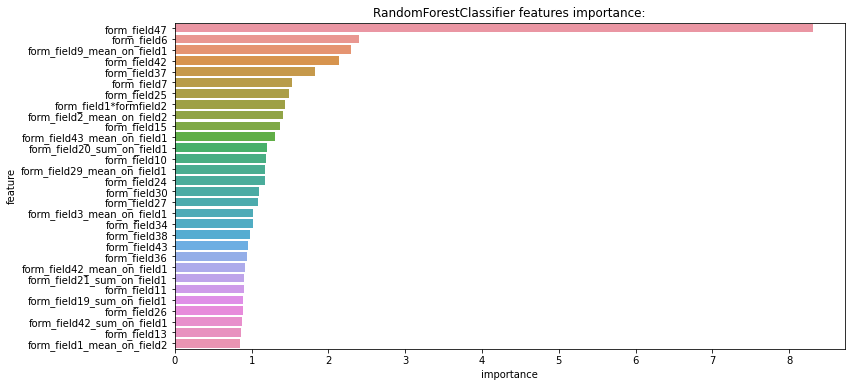

In [125]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

In [ ]:
grid = {'learning_rate': [ 0.05],}
        #'n_estimators': [300, 500] }
       # 'depth': [4,6],}
        #'l2_leaf_reg': [3, 5]}

"""grid_search_result = cat.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)"""

In [ ]:
cat = CatBoostClassifier(task_type='GPU', depth=7, n_estimators=1500, early_stopping_rounds=50)


gscv = GridSearchCV(cat, param_grid=grid)

Tried GridSearch CV

In [ ]:
gscv.fit(X_train, y_train)

In [ ]:
gscv_pred = gscv.predict_proba(X_test)[:,1]
roc_auc_score(y_test, gscv_pred)


In [ ]:
\\prediction = gscv.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission4.csv', index=False)


In [ ]:
cat = CatBoostClassifier(task_type='GPU', learning_rate=0.03, depth=4, n_estimators=3000, early_stopping_rounds=50)

cat.fit(X_train, y_train, eval_set=(X_test, y_test))

In [ ]:
from sklearn.metrics import roc_auc_score, log_loss

In [ ]:
pred = cat.predict_proba(X_test)[:,1]

In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)


In [ ]:
roc_auc_score(y_test, pred)

In [ ]:
models = [cat, xgb, lgb, ada, rf, lr]

for model in models:
    model.fit(X_train, y_train)
    pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test,pred)
    print(f'the auc score for {model} is {score}')

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

In [ ]:
submission.head()

In [ ]:
prediction = cat.predict_proba(test_sc)[:,1]

submission['default_status']=prediction
submission.to_csv('submission3.csv', index=False)


In [ ]:
submission.to_csv('submission3.csv', index=False)

In [ ]:
len(cat.feature_importances_)
len(test_.columns)

In [ ]:
pip install seaborn

In [ ]:
import seaborn as sns

In [ ]:
feature_importance_df = pd.DataFrame(cat.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = test_.columns

plt.figure(figsize=(12, 6));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(30))
plt.title('RandomForestClassifier features importance:');

## Feature Engineering

In [ ]:
new_train.loc[new_train.form_field1>=3500,'form_field1']=1